In [1]:
import csv
from lxml import etree as et
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import networkx as nx
from random import random, sample
import numpy as np

In [2]:
# osm_file='data/graph.osm'
# f = open('data/orig_houses.txt', 'r')
# houses_id = [house[:-1] for house in f.readlines()]
# f.close()
# f = open('data/orig_med.txt', 'r')
# med_id = [med[:-1] for med in f.readlines()]   
# f.close()

# G = nx.DiGraph()
# context = et.iterparse(osm_file, events=('end',), tag='node')
# nodes = {}
# for event, elem in context:
#     #Поменял lon и lat местами для разворота
#     nodes[elem.get('id')] = [float(elem.get('lon')),float(elem.get('lat'))]
#     elem.clear()
#     while elem.getprevious() is not None:
#         del elem.getparent()[0]
# del context
# G.add_nodes_from(nodes)

# def distance(node1,node2):
#     R = 6373.0
#     lat1 = radians(nodes[node1][1])#lat
#     lon1 = radians(nodes[node1][0])#lon
#     lat2 = radians(nodes[node2][1])
#     lon2 = radians(nodes[node2][0])

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c
#     return distance

# def nearest_node_id(node_a_id, pass_list = []):    
#     min_dist = float('inf')
#     if pass_list.count(node_a_id) == 0:
#         pass_list.append(node_a_id)
#     for node_b_id in list(G.nodes()):
#         d = distance(node_a_id,node_b_id)
#         if d < min_dist and node_b_id not in pass_list:
#             min_dist = d
#             nni = node_b_id
#     return nni

# context = et.iterparse(osm_file,events=('end',),tag='way')
# edges = []
# for event, elem in context:
#     oneway = 0
#     #Определим свойства
#     for child in elem.iterchildren('tag'):
#         key = child.get('k')      
#         #Возможно, дорога односторонняя
#         if key == 'oneway' and child.get('v') == 'yes':
#             oneway = 1
#     #Узнаем, какие вершины состоят в пути
#     nodes_list = []
#     for child in elem.iterchildren('nd'):
#         _id = child.get('ref')
#         nodes_list.append(_id)
#     #Добавляем ребра с весами в список смежности
#     if False:#oneway == 1:
#         for i in range(len(nodes_list)-1):
#             #Добавляем вершины
#             from_node, to_node = nodes_list[i:i+2]
#             d = distance(from_node, to_node)
#             edges.append((from_node, to_node, {'weight': d}))
#     else:
#         for i in range(len(nodes_list)-1):
#             from_node, to_node = nodes_list[i:i+2]
#             d = distance(from_node, to_node)
#             edges.append((from_node, to_node, {'weight': d}))
#             edges.append((to_node, from_node, {'weight': d}))
#     elem.clear()
#     while elem.getprevious() is not None:
#         del elem.getparent()[0]
# del context
# G.add_edges_from(edges)    

# #Удалим лишнее
# for node in nodes:
#     if (len(list(G.successors(node))) == 1 or len(list(G.predecessors(node)))) == 1 and G.degree(node) != 1:
#         remove_list,add_list = [],[]
#         for from_node in G.predecessors(node):
#             for to_node in G.successors(node):
#                 remove_list.append((from_node,node))
#                 remove_list.append((node,to_node))
#                 add_list.append((from_node, to_node, {'weight':G[from_node][node]['weight']+G[node][to_node]['weight']}))
#         G.add_edges_from(add_list)
#         G.remove_edges_from(remove_list)
#         G.remove_node(node)

# remove_nodes = [node for node in G.nodes() if int(G.degree(node)) == 0]


# nearest_node_id_for_house,nearest_node_id_for_med = set(),set()
# for h_id in houses_id:
#     nni = nearest_node_id(h_id,remove_nodes)
#     nearest_node_id_for_house.add(nni)

# for m_id in med_id:
#     nni = nearest_node_id(m_id,remove_nodes)
#     nearest_node_id_for_med.add(nni) 

# with open('data/houses.txt','w',newline='') as f:      
#     s = '\n'.join(list(nearest_node_id_for_house))
#     f.write(s+' ')
    
# with open('data/med.txt','w',newline='') as f:      
#     s = '\n'.join(list(nearest_node_id_for_med))
#     f.write(s+' ')

In [3]:
def create_graph_from_osm(osm_file='data/orig_graph.osm'): 
    f = open('data/houses.txt', 'r')
    houses_id = [house[:-1] for house in f.readlines()]
    f.close()
    f = open('data/med.txt', 'r')
    med_id = [med[:-1] for med in f.readlines()]   
    f.close()

    G = nx.DiGraph()
    context = et.iterparse(osm_file, events=('end',), tag='node')
    nodes = {}
    for event, elem in context:
        #Поменял lon и lat местами для разворота
        nodes[elem.get('id')] = [float(elem.get('lon')),float(elem.get('lat'))]
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context
    G.add_nodes_from(nodes)
    
    def distance(node1,node2):
        R = 6373.0
        lat1 = radians(nodes[node1][1])#lat
        lon1 = radians(nodes[node1][0])#lon
        lat2 = radians(nodes[node2][1])
        lon2 = radians(nodes[node2][0])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance

    def nearest_node_id(node_a_id, pass_list = []):    
        min_dist = float('inf')
        if pass_list.count(node_a_id) == 0:
            pass_list.append(node_a_id)
        for node_b_id in list(G.nodes()):
            d = distance(node_a_id,node_b_id)
            if d < min_dist and node_b_id not in pass_list:
                min_dist = d
                nni = node_b_id
        return nni
   
    context = et.iterparse(osm_file,events=('end',),tag='way')
    edges = []
    for event, elem in context:
        oneway = 0
        #Определим свойства
        for child in elem.iterchildren('tag'):
            key = child.get('k')      
            #Возможно, дорога односторонняя
            if key == 'oneway' and child.get('v') == 'yes':
                oneway = 1
        #Узнаем, какие вершины состоят в пути
        nodes_list = []
        for child in elem.iterchildren('nd'):
            _id = child.get('ref')
            nodes_list.append(_id)
        #Добавляем ребра с весами в список смежности
        if False:#oneway == 1:
            for i in range(len(nodes_list)-1):
                #Добавляем вершины
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node)
                edges.append((from_node, to_node, {'weight': d}))
        else:
            for i in range(len(nodes_list)-1):
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node)
                edges.append((from_node, to_node, {'weight': d}))
                edges.append((to_node, from_node, {'weight': d}))
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context
    G.add_edges_from(edges)    
    
    #Удалим лишнее
    for node in nodes:
        if (len(list(G.successors(node))) == 1 or len(list(G.predecessors(node)))) == 1 and G.degree(node) != 1:
            remove_list,add_list = [],[]
            for from_node in G.predecessors(node):
                for to_node in G.successors(node):
                    remove_list.append((from_node,node))
                    remove_list.append((node,to_node))
                    add_list.append((from_node, to_node, {'weight':G[from_node][node]['weight']+G[node][to_node]['weight']}))
            G.add_edges_from(add_list)
            G.remove_edges_from(remove_list)
            G.remove_node(node)
    
    remove_nodes = [node for node in G.nodes() if int(G.degree(node)) == 0]
    
    for h_id in houses_id:
        w = 1 + random()
        for node in G.successors(h_id):
            G[h_id][node]['weight'] *= w
        for node in G.predecessors(h_id):
            G[node][h_id]['weight'] *= w
        
    for m_id in med_id:
        w = 1 + random()
        for node in G.successors(m_id):
            G[m_id][node]['weight'] *= w
        for node in G.predecessors(m_id):
            G[node][m_id]['weight'] *= w    
    
    G.remove_nodes_from(remove_nodes)
#     houses_id = houses_id[0:100]   
#     med_id = med_id[0:10]
    return G,houses_id,med_id,nodes

In [4]:
# def create_graph_from_osm(osm_file='data/graph.osm'):        
#     f = open('data/additional_nodes.txt', 'r')
#     additional_nodes_id = [node[:-1] for node in f.readlines()]
#     f.close()
    
#     #В целом можно без этого достать веса и убрать G_ox  c nodes_info
#     G_ox = ox.core.graph_from_file(osm_file,  simplify=False, retain_all=True)
#     nodes_info = [[str(node) for node in G_ox.nodes], G_ox.nodes(data=True)]
    
#     def distance(node1,node2):
#         R = 6373.0
#         lon1 = radians(nodes_info[int(node1)]['x'])#lon
#         lat1 = radians(nodes_info[int(node1)]['y'])#lat
#         lon2 = radians(nodes_info[int(node2)]['x'])
#         lat2 = radians(nodes_info[int(node2)]['y'])

#         dlon = lon2 - lon1
#         dlat = lat2 - lat1

#         a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#         c = 2 * atan2(sqrt(a), sqrt(1 - a))

#         distance = R * c
#         return distance

#     def nearest_node_id(node_a_id, pass_list = []):    
#         min_dist = float('inf')
#         if pass_list.count(node_a_id) == 0:
#             pass_list.append(node_a_id)
#         for node_b_id in nodes_info[0]:
#             d = distance(node_a_id,node_b_id)
#             if d < min_dist and node_b_id not in pass_list:
#                 min_dist = d
#                 nni = node_b_id
#         return nni
    
#     G = nx.DiGraph(G_ox)
    
#     f = open('100houses.txt', 'r')
#     houses_id = [house[:-1] for house in f.readlines()]
#     f.close()
#     f = open('10med.txt', 'r')
#     med_id = [med[:-1] for med in f.readlines()]
#     f.close()
    
#     nearest_node_id_for_house,nearest_node_id_for_med = [],[]
#     for h_id in houses_id:
#         #И тут
#         nni = nearest_node_id(h_id,additional_nodes_id)
#         w = 1 + random()
#         nearest_node_id_for_house.append(nni)
#         for node in G.successors(nni):
#             G[nni][node]['weight'] *= w
#         for node in G.predecessors(nni):
#             G[node][nni]['weight'] *= w
            
#     for m_id in med_id:
#         #И тут
#         nni = nearest_node_id(m_id,additional_nodes_id)
#         w = 1 + random()
#         nearest_node_id_for_med.append(nni)
#         for node in G.successors(nni):
#             G[nni][node]['weight'] *= w
#         for node in G.predecessors(nni):
#             G[node][nni]['weight'] *= w

            
#     houses_id = nearest_node_id_for_house.copy()
#     med_id = nearest_node_id_for_med.copy()
    
#     return G,houses_id,med_id


In [5]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.g[self.heap[i]]['index'], self.g[self.heap[smallest]]['index'] = self.g[self.heap[smallest]]['index'], self.g[self.heap[i]]['index']           
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)

    def build_min_heap(self,_NodeView):
        self.heap = [None for i in range(len(_NodeView))]
        for elem in self.g:
            self.heap[self.g[elem]['index']] = elem
#         self.heap = list(_NodeView)
        self.size = len(_NodeView)
#         for i in range(len(_NodeView)//2,-1,-1):
#             self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.g[self.heap[self.size-1]]['index'] = self.g[self.heap[0]]['index']
        self.heap[0] = self.heap[self.size-1]      
        self.size -= 1
        self.min_heapify(0)
        return _min
    
    def decrease_key(self,_id,key):
        i = self.g[_id]['index']
        if key > self.g[_id]['weight']:
            raise KeyError
        self.g[_id]['weight'] = key
        while (i > 0) and (self.g[self.heap[self.parent_index(i)]]['weight'] > self.g[self.heap[i]]['weight']):
            self.g[self.heap[self.parent_index(i)]]['index'], self.g[self.heap[i]]['index'] = self.g[self.heap[i]]['index'], self.g[self.heap[self.parent_index(i)]]['index']
            self.heap[self.parent_index(i)], self.heap[i] = self.heap[i], self.heap[self.parent_index(i)]
            i = self.parent_index(i)

            
def initialize_single_sourse(G,_from):
    g = {}
    nodes_list = list(G.nodes).copy()
    nodes_list.remove(_from)
    for v_id, i in zip(nodes_list,range(1,len(G.nodes))):
        g[v_id] = {'way': [], 'weight':float('inf'), 'index':i}
    g[_from] = {'way':[_from], 'weight':0, 'index':0}
    return g

def relax(G,min_heap,_from,_to):
    if min_heap.g[_to]['weight'] > min_heap.g[_from]['weight'] + G[_from][_to]['weight']:
        key = min_heap.g[_from]['weight'] + G[_from][_to]['weight']
        min_heap.decrease_key(_to,key)
        min_heap.g[_to]['way'] = (min_heap.g[_from]['way']).copy()
        min_heap.g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list = 'empty'):
    if to_list == 'empty':
        to_list = list(G.nodes)
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(G.nodes)
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,nodes,u,v)
    return g


In [6]:
def create_adj_list(filename = 'adj_list2.csv'):
    with open(filename,'w',newline='') as csv_file:
        csv_file.write('from_id to_id,edge_weight\n')
        for _from in list(G.nodes):
            s = str(_from)
            for _to in G.successors(_from):
                s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
            csv_file.write(s + '\n')

In [7]:
def write_dijkstra_csv(G,filename,from_list,to_list):
    with open(filename,'w',newline='') as f:
        f.write('from,to,way_weight,way\n')
        for _from in from_list:
            a = dijkstra(G,_from,to_list)
            a = {k:v for k,v in a.items() if v["weight"] != float('inf')}
            for _to in to_list:
                if _to in a.keys():
                    s = _from + ',' + _to + ',' + str(a[_to]['weight'])
                    way = ','.join(a[_to]['way'])
                    s = s + ',' + way
                    f.write(s + '\n')

def read_dijkstra_csv(filename):
    min_ways = {}         
    with open(filename,'r') as f:
        lines = f.readlines()
        lines = lines[1:] 
        for line in lines:
            split_line = line[:-1].split(',')
            _from = split_line[0]
            _to = split_line[1]
            weight = float(split_line[2])
            if weight != float('inf'):
                way = split_line[3:]
            else: 
                way = []             
            if min_ways.get(_from) == None:
                min_ways[_from] = {_to:{'weight':weight,'way':way}}
            else:
                min_ways[_from][_to] = {'weight':weight,'way':way}
                
    return min_ways
            


In [8]:
def write_ways(filename,min_way):
    with open(filename,'w',newline='') as f:  
        f.write('from_id,to_id,way_weight\n')
        s = ''
        for _from in min_way.keys():
            s = s + _from + ',' + min_way[_from]['to'] + ',' + str(min_way[_from]['weight'])+'\n'
        f.write(s)


In [9]:
def search_min_oneways(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys():
                    if min_way.get(_from) == None:
                        min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
                    elif min_ways[_from][_to]['weight'] < min_way[_from]['weight']:
                        min_way[_from]['to'] = _to
                        min_way[_from]['weight'] = min_ways[_from][_to]['weight']                    
                        min_way[_from]['way'] =  min_ways[_from][_to]['way']
    return min_way


In [10]:
def search_min_ways_there_and_back(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                    if min_way.get(_from) == None:
                        min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight'],'way':min_ways[_from][_to]['way'],'way_back':min_ways[_to][_from]['way']}
                    elif min_way[_from]['weight'] > min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']:
                        min_way[_from]['to'] = _to
                        min_way[_from]['weight'] = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                        min_way[_from]['way'] =  min_ways[_from][_to]['way']
                        min_way[_from]['way_back'] = min_ways[_to][_from]['way']
    return min_way


In [11]:
def search_near_ways(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] <= max_weight and _from != _to:
                    near_ways.append([_from,_to,min_ways[_from][_to]['weight'],min_ways[_from][_to]['way']])
    return near_ways
                

In [12]:
def search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                weight = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                if weight <= max_weight and _from != _to:
                    near_ways.append([_from, _to, weight, min_ways[_from][_to]['way'], min_ways[_to][_from]['way']])
    return near_ways


In [13]:
def search_minmax_way(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = {obj:{'weight':float('inf')}}
    for _from in from_list:
        weight = 0
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] > weight:
                    to = _to
                    weight = min_ways[_from][_to]['weight']
        if weight != 0 and weight < minmax_way[obj]['weight']:
            minmax_way = {_from:{'to':to,'weight':weight}}
            obj = _from
    if obj != 'start':
        minmax_way[obj]['way'] = min_ways[obj][minmax_way[obj]['to']]['way'].copy()
    
    return minmax_way


In [14]:
def search_minmax_way_there_and_back(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = []
    for _from in from_list:
        if _from in min_ways.keys():
            weight = 0
            for _to in to_list:
                if _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                    w0 = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                    if w0 > weight:
                        to = _to
                        weight = w0
                    if minmax_way == [] or weight < minmax_way[2]: 
                        obj = _from 
                        minmax_way = [obj,to,weight]
      
    if  obj != 'start':
        minmax_way.append(min_ways[obj][to]['way'])
        minmax_way.append(min_ways[to][obj]['way'])
        minmax_way = [minmax_way]
    
    return minmax_way


In [15]:
def search_min_distance_to_node(min_ways,from_list,to_list,mean=False, func = sum):
    #Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
    min_sum = float('inf')
    ways = []
    obj = ''
    for _from in from_list:
        if _from in min_ways.keys():
            _sum_elem = []
            for _to in to_list:
                if _to in min_ways[_from].keys() and _from != _to:                  
                    _sum_elem.append(min_ways[_from][_to]['weight'])
            if _sum_elem != [] and func(_sum_elem) < min_sum:
                min_sum = func(_sum_elem)
                obj = _from
                
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])

    return obj,min_sum,ways


In [16]:
def search_min_weight_to_node(min_ways,from_list,to_list, func = sum):
    #Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.
    min_sum = float('inf')
    obj = ''
    for _from in from_list:
        if _from in min_ways.keys():
            _sum_elem = []
            edges_set = set()        
            for _to in to_list:
                if _to in min_ways[_from].keys() and _from != _to:
                    edges_set.add(_from + ' ' + _to)
            for elem in list(edges_set):
                i,j = elem.split(' ')
                _sum_elem.append(min_ways[i][j]['weight'])
            
            if _sum_elem != [] and func(_sum_elem) < min_sum:
                min_sum = func(_sum_elem)
                obj = _from
    ways = []
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])
    
    return obj,min_sum,ways


In [17]:
def draw_ways_on_graph(G,nodes,ways,filename=''):
    if type(ways) == dict:
        ways = [way['way'] for way in ways.values()]
    elif type(ways) == list:
        ways = [way[3] for way in ways]
    edgelist,nodedict,start,end = [],set(),[],[]
    for way in ways:
        start.append(way[0])
        end.append(way[-1])
        for edge in zip(way[:-1],way[1:]):
            edgelist.append(edge)
            nodedict.add(edge[1])
    nodedict = list(nodedict)
    
    fig = plt.gcf()
    fig.set_size_inches(16,22,forward = True)
    nx.draw_networkx(G, pos = nodes, node_size = 0, width = 0.1, with_labels = False, arrows  = False)
  
    nx.draw_networkx_edges(G.subgraph(start+nodedict),pos = nodes,edgelist = edgelist,edge_color='b',width = 0.4,arrows  = False)
    nx.draw_networkx_nodes(G.subgraph(start),pos = nodes,nodelist = start,node_color='g',node_size=15)
    nx.draw_networkx_nodes(G.subgraph(end),pos = nodes,nodelist = end,node_color='b',node_size=15)
    
    if filename != '':
        plt.savefig(filename,dpi=1000)
        fig.clear()

In [18]:
def draw_graph(G,nodes,filename=''):
    fig = plt.gcf()
    fig.set_size_inches(16,22,forward = True)
    nx.draw_networkx(G, pos = nodes, node_size = 0, width = 0.1, with_labels = False, arrows  = False)
    if filename != '':
        plt.savefig(filename,dpi=1000)
        fig.clear()

In [19]:
%time G,houses_id,med_id,nodes = create_graph_from_osm()

Wall time: 2.99 s


In [20]:
#Время работы для случайных вершин
#%time dijkstra(G,'419051330',med_id)

In [21]:
# from_list = sample(houses_id, 100)
# to_list = sample(med_id, 10)  
from_list = houses_id[:100]
to_list = med_id[:10]

In [22]:
%time write_dijkstra_csv(G,'data/dijkstra1',from_list,to_list)
%time write_dijkstra_csv(G,'data/dijkstra2',to_list,from_list)

Wall time: 4min 23s
Wall time: 25.6 s


In [23]:
min_ways = read_dijkstra_csv('data/dijkstra1')
min_ways.update(read_dijkstra_csv('data/dijkstra2'))
max_weight = 10#km
#Если нужно без записи
#res = []
#for _from in from_list:
#    res.append(dijkstra(G,_from,to_list))

#1a
min_oneways1 = search_min_oneways(min_ways,from_list,to_list)
min_oneways2 = search_min_oneways(min_ways,to_list,from_list)
min_ways_there_and_back = search_min_ways_there_and_back(min_ways,from_list,to_list)

#1b
near_ways1 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways2 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways_there_and_back = search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list)

#2
minmax_way1 = search_minmax_way(min_ways,from_list,to_list)
minmax_way2 = search_minmax_way(min_ways,from_list,to_list)
minmax_way_there_and_back = search_minmax_way_there_and_back(min_ways,from_list,to_list)

#3
min_distance_to_node,min_distance,min_distance_way = search_min_distance_to_node(min_ways,from_list,to_list,sum)#np.mean)
#4
min_weight_to_node,min_weight,min_weight_way = search_min_weight_to_node(min_ways,from_list,to_list,sum)

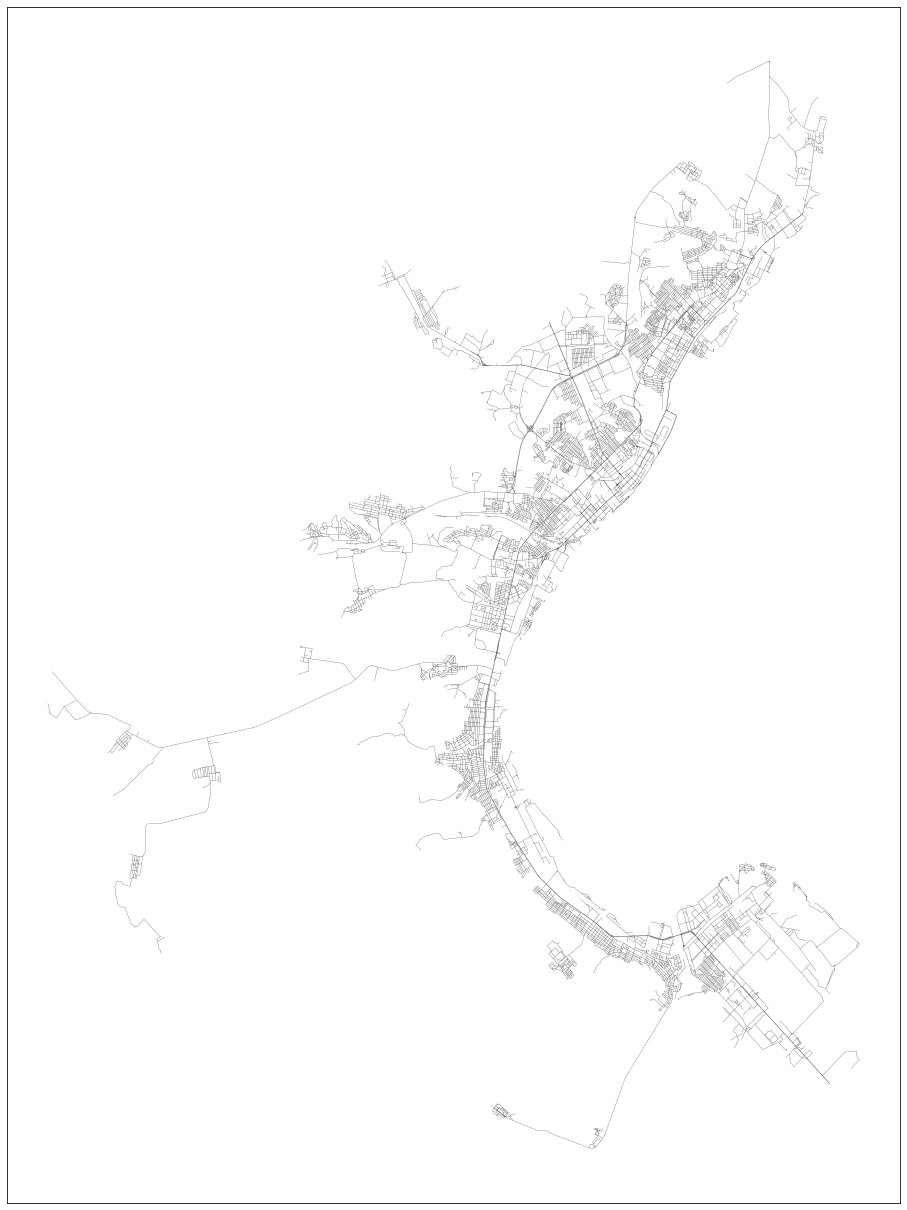

In [24]:
draw_graph(G,nodes)#'data/Volograd.png')

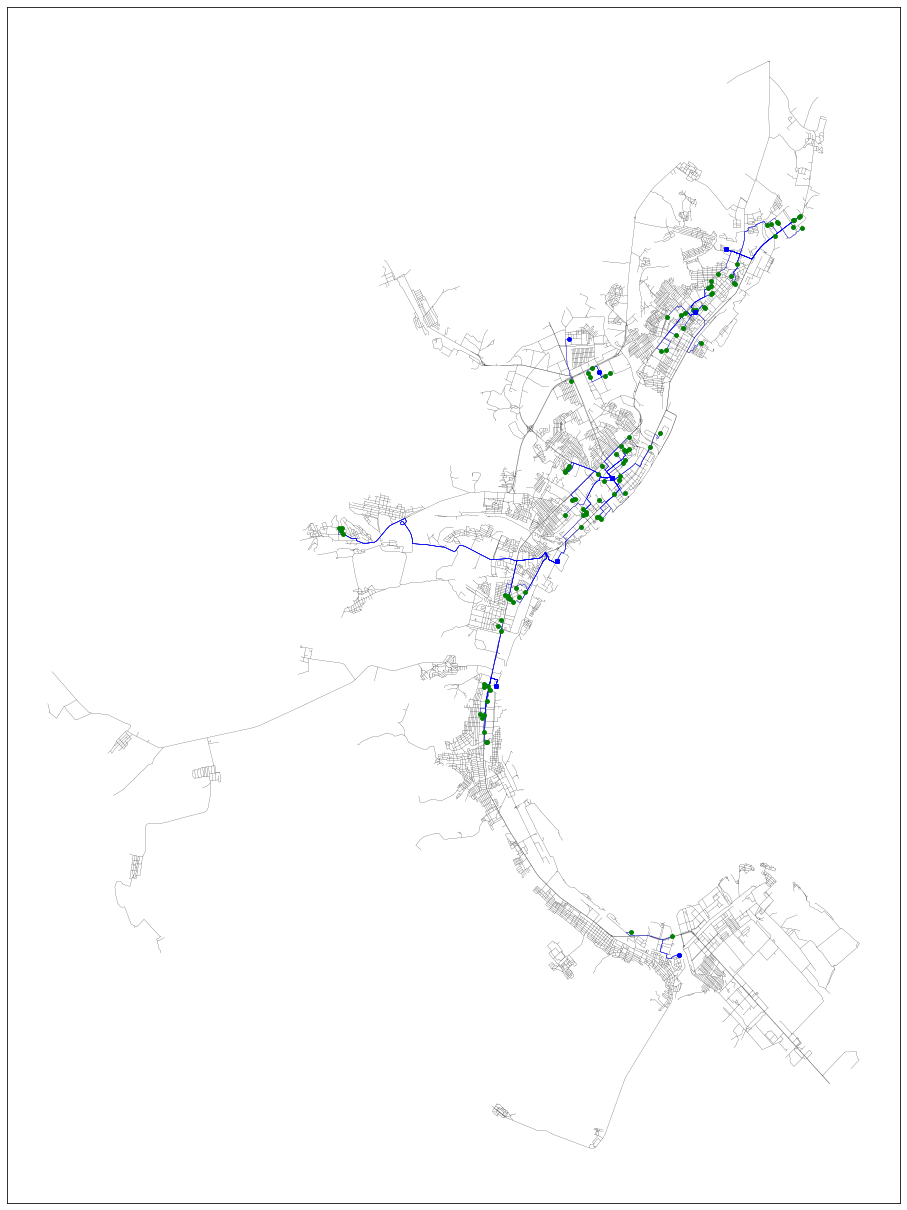

In [25]:
draw_ways_on_graph(G,nodes,min_oneways1)

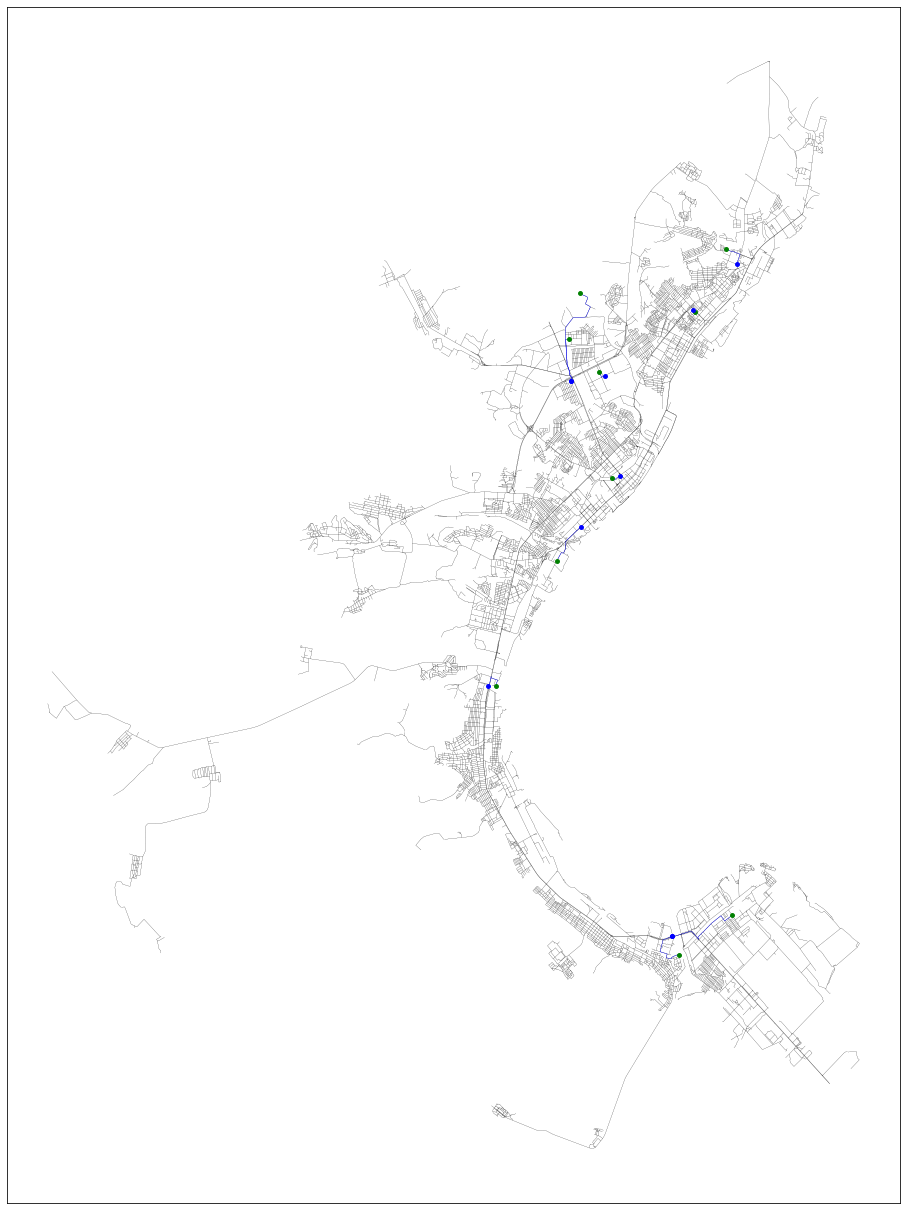

In [26]:
draw_ways_on_graph(G,nodes,min_oneways2)

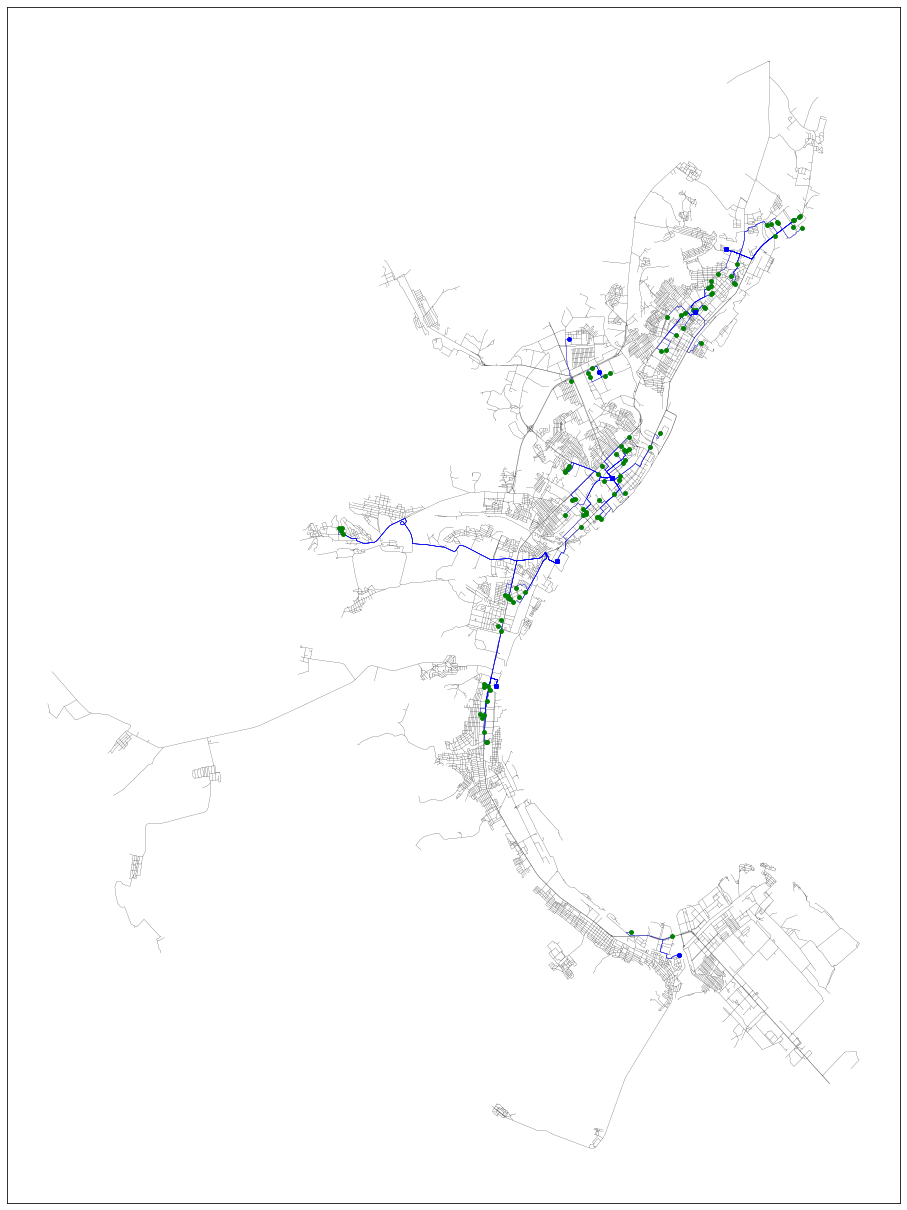

In [27]:
draw_ways_on_graph(G,nodes,min_ways_there_and_back)

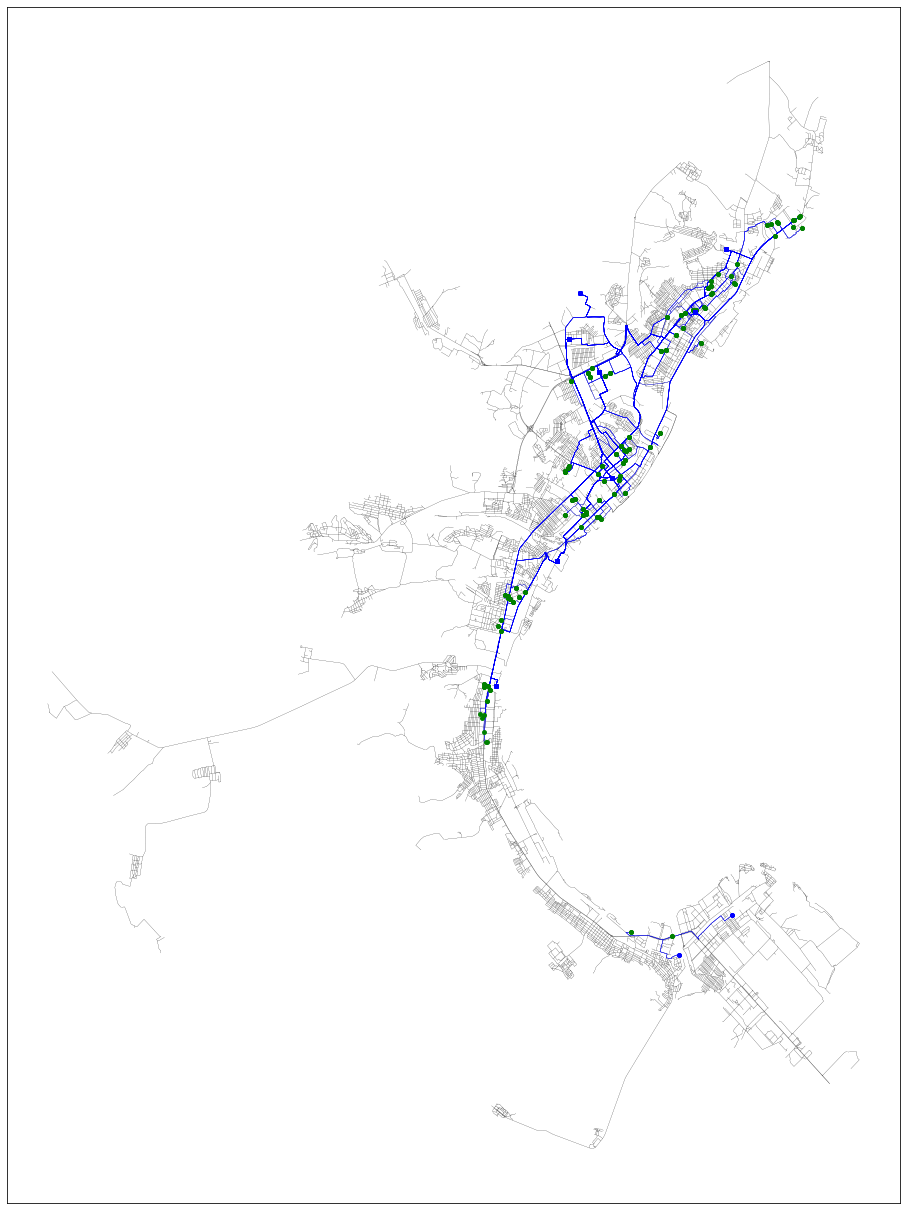

In [28]:
draw_ways_on_graph(G,nodes,near_ways1)

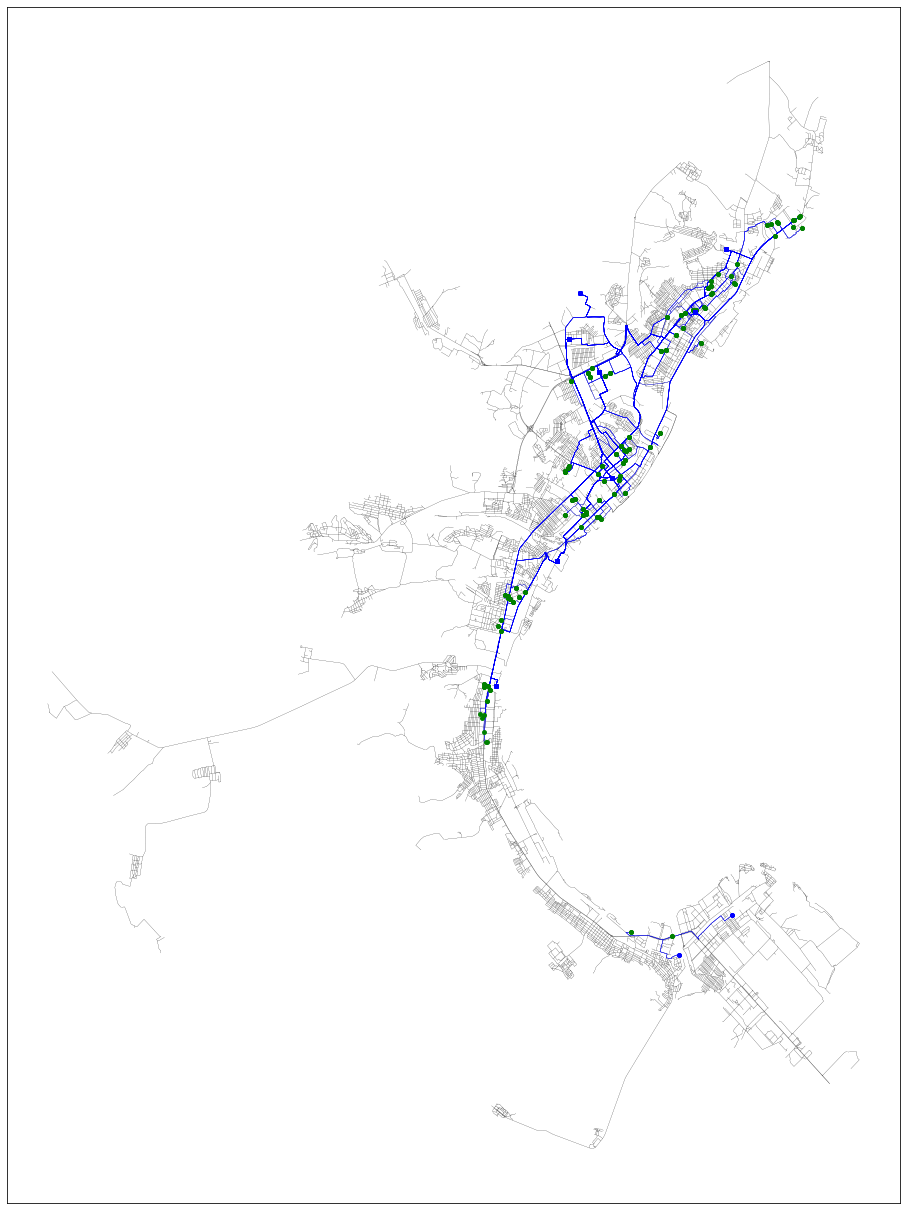

In [29]:
draw_ways_on_graph(G,nodes,near_ways2)

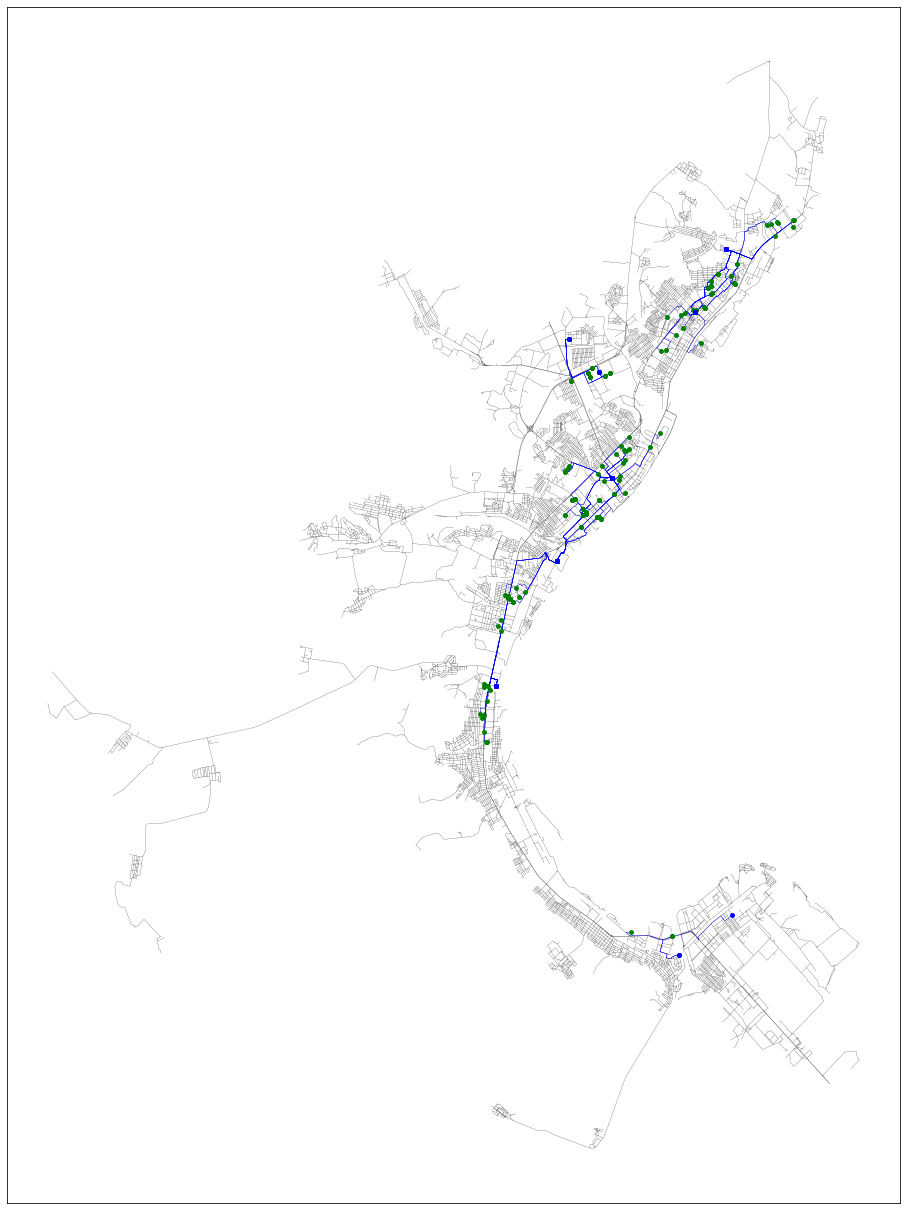

In [30]:
draw_ways_on_graph(G,nodes,near_ways_there_and_back)

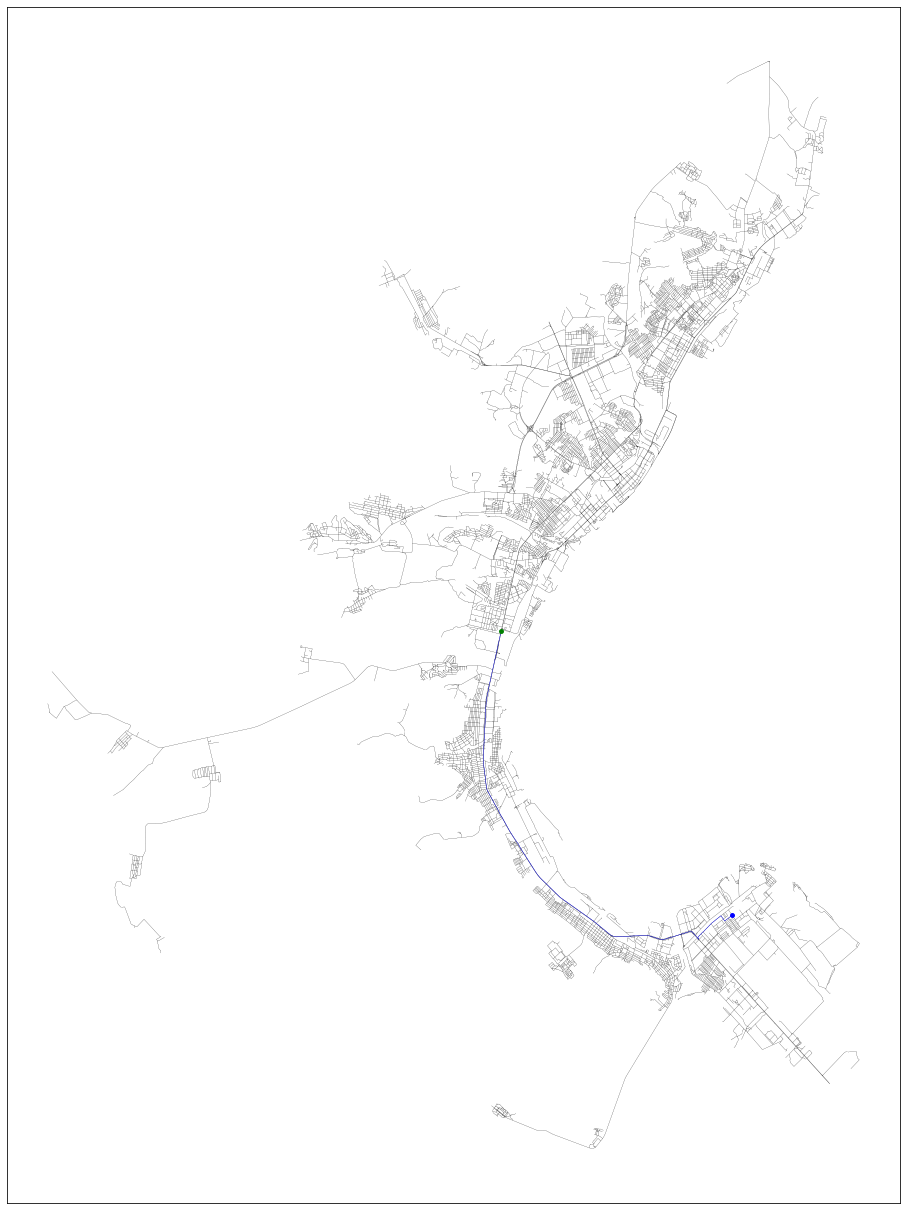

In [31]:
draw_ways_on_graph(G,nodes,minmax_way1)

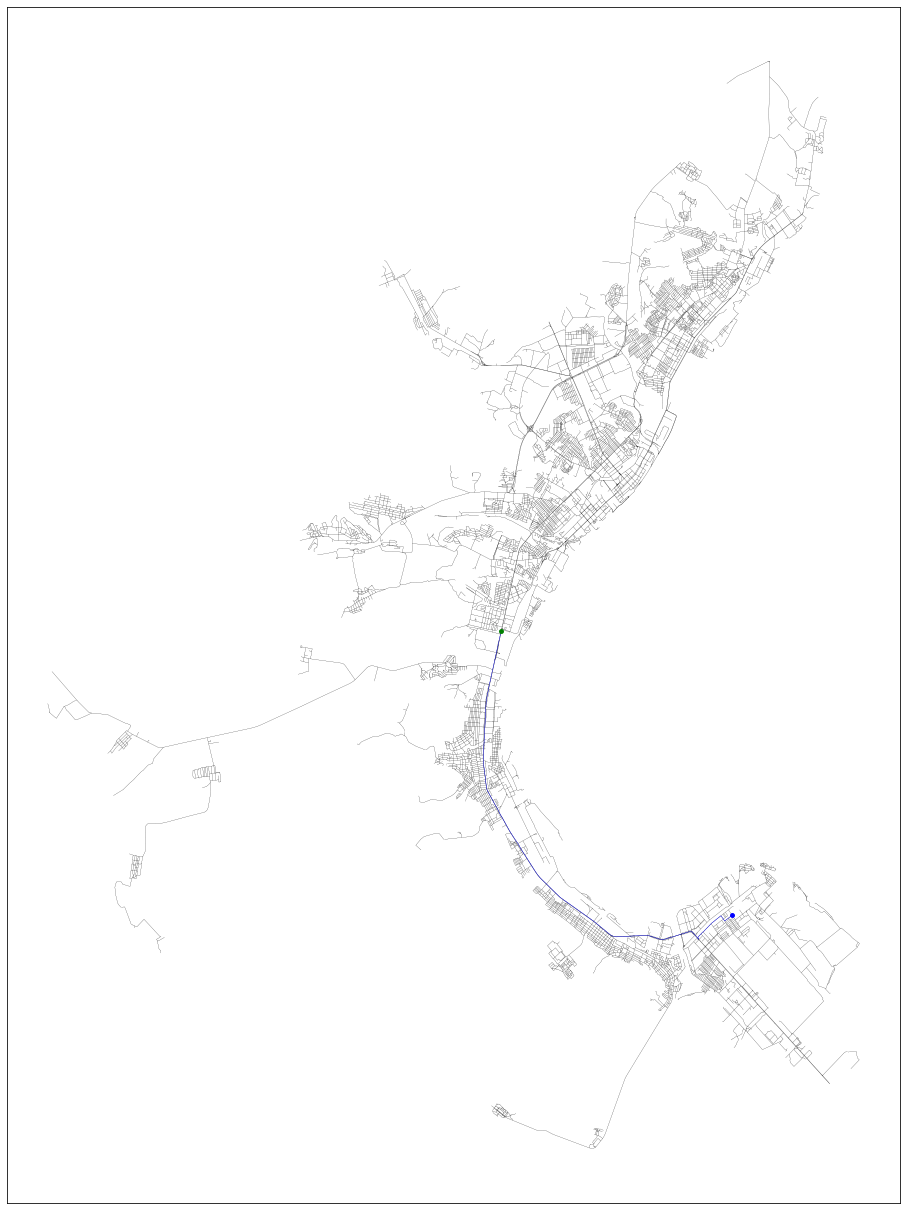

In [32]:
draw_ways_on_graph(G,nodes,minmax_way2)

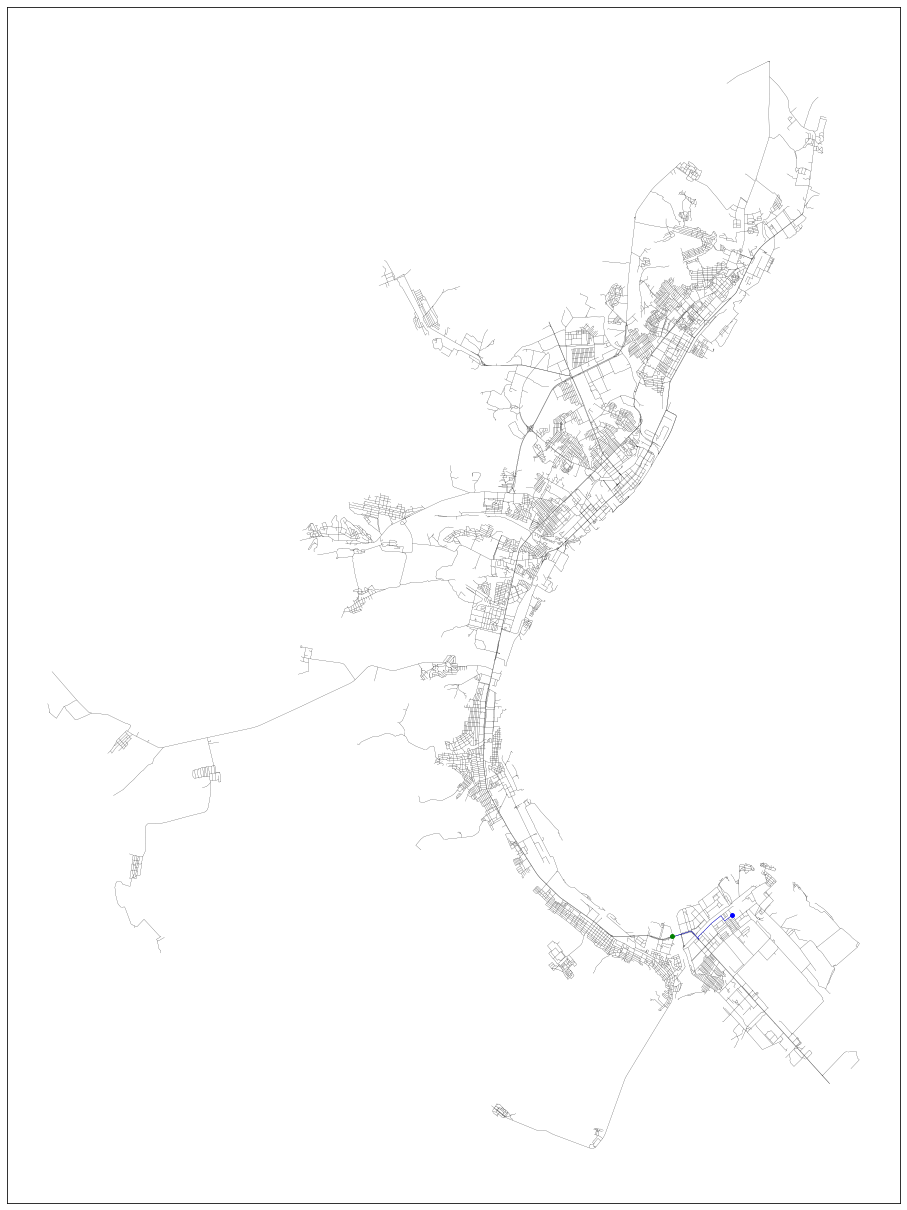

In [33]:
draw_ways_on_graph(G,nodes,minmax_way_there_and_back)

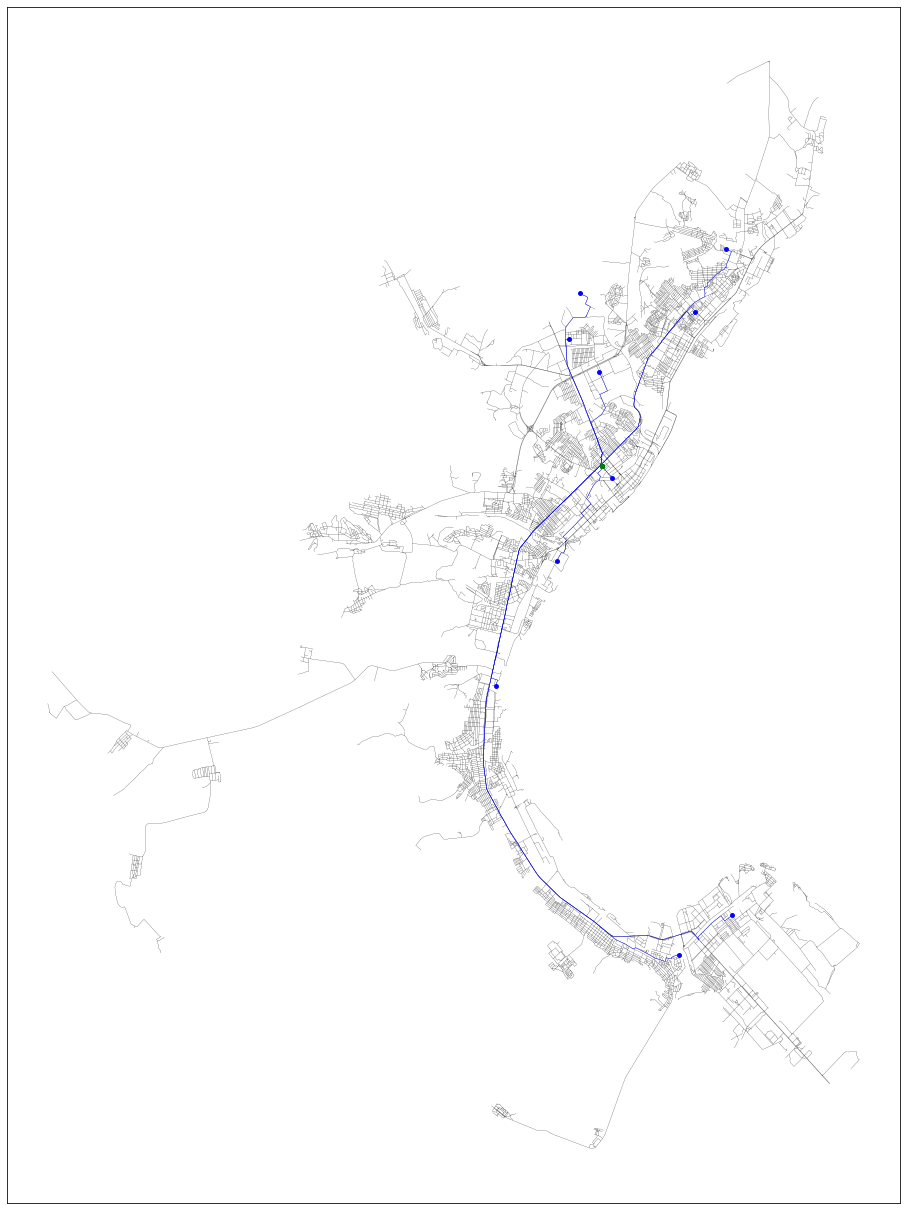

In [34]:
draw_ways_on_graph(G,nodes,min_distance_way)

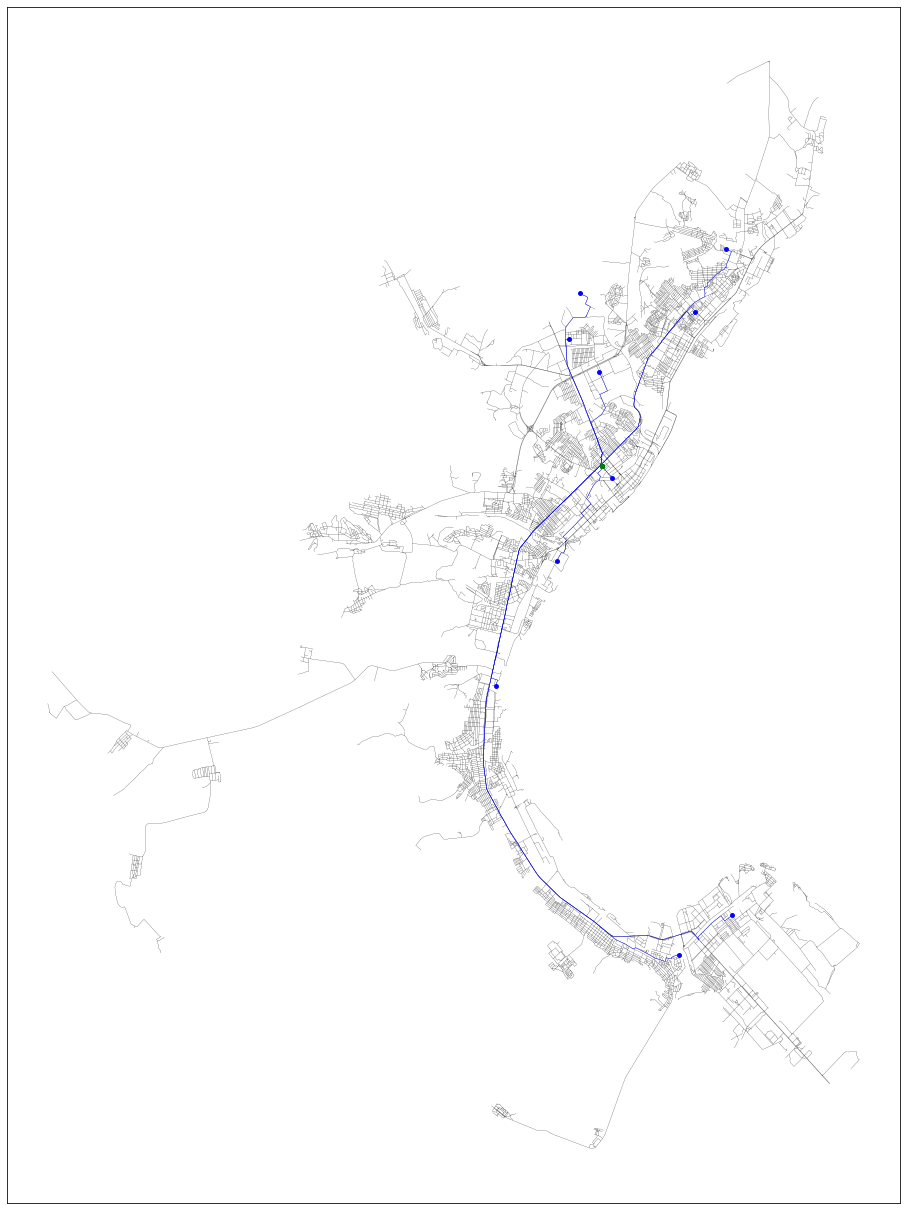

In [35]:
draw_ways_on_graph(G,nodes,min_weight_way)

In [36]:
def draw_ways(_map,ways_orig):
    if type(ways_orig) == dict:
        ways = [way['way'] for way in ways_orig.values()]
        if 'way_back' in ways_orig[list(ways_orig.keys())[0]].keys():
            ways += [way['way_back'] for way in ways_orig.values()]
    elif type(ways_orig) == list:
        ways = [way[3] for way in ways_orig]
        if len(ways_orig[0]) == 5:
            ways += [way[4] for way in ways_orig]
    ways = list(map(lambda x: (list(map(int,x))),ways))

    ox.plot_graph_routes(_map, ways)
 

In [37]:
import osmnx as ox
_map = ox.core.graph_from_file('data/graph.osm',  simplify=False, retain_all=False)


AttributeError: 'NoneType' object has no attribute 'values'

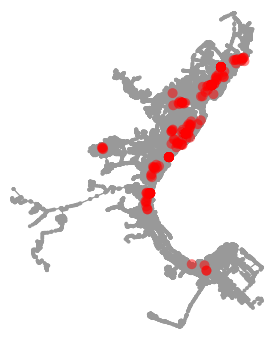

In [38]:
draw_ways(_map, min_oneways1)

In [ ]:
draw_ways(_map, min_oneways2)

In [ ]:
draw_ways(_map, min_ways_there_and_back)

In [ ]:
draw_ways(_map, near_ways1)

In [ ]:
draw_ways(_map, near_ways2)

In [ ]:
draw_ways(_map, near_ways_there_and_back)

In [ ]:
draw_ways(_map, minmax_way1)

In [ ]:
draw_ways(_map, minmax_way2)

In [ ]:
draw_ways(_map, minmax_way_there_and_back)

In [ ]:
draw_ways(_map,min_distance_way)

In [ ]:
draw_ways(_map,min_weight_way)

In [ ]:
#Часть для Вовы

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [ ]:
def get_tree_and_sum(G, _from, target_list):
    tree = dijkstra(G, _from, target_list)
    filtered_tree = {k:v for k,v in tree.items() if v["weight"] != float('inf') and k in target_list}
    tree_sum = sum(list(map(lambda x: x['weight'], list(filtered_tree.values()))))
    
    edge_set = list()
    for target in filtered_tree:
        node_list = filtered_tree[target]['way']
        for node_number in range(len(node_list)-1):           
            new_edge = [node_list[node_number], node_list[node_number + 1]]
            if new_edge not in edge_set:
                edge_set.append(new_edge)
    tree_small_sum = sum(list(map(lambda x: G[x[0]][x[1]]['weight'], edge_set)))
    return filtered_tree, tree_sum, tree_small_sum



In [ ]:
G_d = ox.graph_from_place('Volgograd', network_type='drive', simplify = False)

In [ ]:
nodes_info = [[str(node) for node in G_d.nodes], G_d.nodes(data=True)]

In [ ]:
temp_tree, temp_tree_sum, temp_tree_small_sum = get_tree_and_sum(G, str(to_list[0]), nodes_info[0][20:50])

In [ ]:
routes_temp = [temp_tree[key]['way'] for key in temp_tree]
routes_temp_2 = list(map(lambda x: [int(value) for value in x][3:-5], routes_temp))

fig, ax = ox.plot_graph_routes(_map, routes_temp_2)

In [ ]:
import collections
matrix = []
for house_id in from_list:
    pre_vector = dijkstra(G, house_id, from_list)
    filtered_vector = {k:v for k,v in pre_vector.items() if v["weight"] != float('inf') and k in from_list}
    sorted_vector = collections.OrderedDict(sorted(filtered_vector.items()))
    vector = list(map(lambda x: x['weight'], list(sorted_vector.values())))
    matrix.append(vector)

In [ ]:
def cluster_to_id_list(cluster_index, cluster_cash, list_id, count_of_values):
    cluster_indexes = [cluster_index]
    while len(list(filter(lambda x: x > count_of_values, cluster_indexes))) > 0:
        cluster_to_open = list(filter(lambda x: x >= count_of_values, cluster_indexes))
        
        for cluster in cluster_to_open:
            cluster_indexes.remove(cluster)
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 0] )
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 1] )
            
    return list(map(lambda x: int(list_id[int(x)]), cluster_indexes))

In [ ]:
def get_centroid_coords(cluster_nodes):
    x = sum(list(map(lambda x: x['x'], cluster_nodes))) / len(cluster_nodes)
    y = sum(list(map(lambda x: x['y'], cluster_nodes))) / len(cluster_nodes)
    return y, x

In [ ]:
for i in range(99):
    if len(matrix[i]) != 100:
        matrix.remove(matrix[i])
        for j in range(len(matrix)):
            matrix[j].remove(matrix[j][i])
print(len(matrix))

In [ ]:
import numpy as np
matrix_np = np.array(matrix)
cluster_cash = linkage(matrix_np, 'complete')
fig = plt.figure(figsize=(25, 20))
dn = dendrogram(cluster_cash)

In [ ]:
def get_cluster_info (cluster_index, cluster_cash, cluster_items_id, nodes_data):    
    cluster_nodes = cluster_to_id_list(cluster_index, cluster_cash, cluster_items_id, len(cluster_cash) + 1)
    str_cluster_nodes = list(map(lambda x: str(x),cluster_nodes))
    list_with_coords = list(map(lambda x: {'x': float(nodes_data[int(x)]['x']), 'y': float(nodes_data[int(x)]['y'])} ,cluster_nodes))
    centroid = get_centroid_coords(list_with_coords)
    centroid_id = ox.get_nearest_node(_map, centroid, method='euclidean')
    tree, tree_sum, tree_min_sum = get_tree_and_sum(G, str(centroid_id), str_cluster_nodes)
    return {'tree': tree, 'tree_sum':tree_sum, 'tree_min_sum':tree_min_sum, 'centroid_id':centroid_id, 'nodes': str_cluster_nodes}

In [ ]:
def open_next_cluster(cluster_cash, clusters, count_of_values):
    cluster_to_open = max(clusters)
    clusters.remove(cluster_to_open)
    clusters.append(cluster_cash[int(cluster_to_open) - count_of_values, 0] )
    clusters.append(cluster_cash[int(cluster_to_open) - count_of_values, 1] )
    return clusters

In [ ]:
clusters = [int(cluster_cash[-1,0]), int(cluster_cash[-1,1])]
cluters_info_2 = list(map(lambda x: get_cluster_info(x, cluster_cash, from_list, nodes_data), clusters))

In [ ]:
clusters = open_next_cluster(cluster_cash, clusters, 100)
cluters_info_3 = list(map(lambda x: get_cluster_info(x, cluster_cash, from_list, nodes_data), clusters))

In [ ]:
clusters = open_next_cluster(cluster_cash, clusters, 100)
clusters = open_next_cluster(cluster_cash, clusters, 100)

cluters_info_5 = list(map(lambda x: get_cluster_info(x, cluster_cash, from_list, nodes_data), clusters))

In [ ]:
from functools import reduce

routes_clusters_str = reduce(lambda x,y: x + y, list(map(lambda x: [v['way'] for k,v in x['tree'].items()], cluters_info_2)))
routes_clusters = list(map(lambda x: list(map(lambda y: int(y), x)), routes_clusters_str))
routes_clisters_filtered = list(filter(lambda x: len(x) > 1, routes_clusters))

for cluster in cluters_info_3:
    print(len(cluster['tree']))

etokomfo = cluters_info_2[0]['tree'][str(tets_node)]['way'][3:-4]
for val in etokomfo:
    if val in from_list:
        print(val)
